In [2]:
import io, requests, glob, os, math
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.api import STLForecast
from statsmodels.tsa.arima.model import ARIMA


In [3]:
# Plot a parameter of a dataframe
def plot_param(params, title, data, log=False):
    params = params if type(params) in (tuple, list) else [params]
    maxDate = data["Datum"].max()
    fig, axs = plt.subplots(5, 2, figsize=(20, 20), constrained_layout=True)
    fig.suptitle(
        f'{title} bis {maxDate.strftime("%d. %b %Y")}',
        fontweight="bold", fontsize="xx-large")
    i = 0

    # Name is the name of the Bundesland. Create a figure for each country.
    for bl in data["Name"].unique():
        data_bl = data.loc[data["Name"] == bl]
        # Figure order: 0  1
        #               2  3 ...
        axis = axs[int(i / 2), i % 2]
        axis.xaxis.set_major_locator(mdates.MonthLocator())
        axis.xaxis.set_minor_locator(
            mdates.WeekdayLocator(byweekday=mdates.MO))
        axis.set_title(bl,
                       fontweight="bold" if bl == "Österreich" else "normal")
        j = 0
        secondAxis = axis.twinx() if len(params) > 1 else None
        # Draw a line for each parameter
        for param in params:
            currentAxis = axis if j == 0 else secondAxis
            if log:
                currentAxis.set_yscale('log')

            res = STL(data_bl.loc[:, param], period=7).fit()
            if j == 0:
                currentAxis.plot(res.observed, linewidth=1)
                currentAxis.plot(res.trend)
            else:
                currentAxis.plot(res.trend, color="black", linewidth=1)
            j = j + 1
        axis.xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
        axis.grid(True, which="minor", axis="x")
        axis.grid(True, which="major", axis="y")
        i = i + 1
        if bl == "Österreich":
            for a in ['top', 'bottom', 'left', 'right']:
                axis.spines[a].set_linewidth(2)
            #plt.rc("figure", figsize=(16, 8))
            #res.plot()
    plt.show()
    fig.savefig(f'{title}_{dt.datetime.now(dt.timezone.utc).strftime("%Y%m%d%H%M%S")}.png', facecolor="white", dpi=96)


In [4]:

requests.packages.urllib3.disable_warnings()
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'

# To avoid ssl error (key to short) we use requests.get
req = requests.get(
    "https://info.gesundheitsministerium.gv.at/data/timeline-faelle-bundeslaender.csv", verify=False)

# Read the result in a dataframe
data = pd.read_table(
    io.StringIO(req.content.decode("utf-8-sig")),
    sep=";", header=0, parse_dates=[0])

with sqlite3.connect("covid.db") as conn:
    data.to_sql(name='DataRaw', con=conn, if_exists='replace', index=False)
    data = pd.read_sql("""
    SELECT 
        d.*,
        AVG(Neuinfektionen) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Neuinfektionen7DayAvg,
        AVG(Hospitalisierung) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS Hospitalisierung7DayAvg,
        AVG(TestungenPCR) OVER(PARTITION BY BundeslandID ORDER BY Datum ROWS BETWEEN 6 PRECEDING AND CURRENT ROW) AS TestungenPCR7DayAvg
    FROM (
        SELECT
            date(Datum, '-1 day') AS Datum,
            BundeslandID, Name, BestaetigteFaelleBundeslaender, Hospitalisierung,
            MAX(0,BestaetigteFaelleBundeslaender - LAG(BestaetigteFaelleBundeslaender, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum)) AS Neuinfektionen,
            MAX(0,TestungenPCR - LAG(TestungenPCR, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum)) AS TestungenPCR,
            Hospitalisierung - LAG(Hospitalisierung, 1) OVER(PARTITION BY BundeslandId ORDER BY Datum) AS HospitalisierungDiff
        FROM DataRaw) d
    """, conn)
    for bl in data["Name"].unique():
        for param in ["TestungenPCR", "HospitalisierungDiff", "Hospitalisierung", "Neuinfektionen"]:
            data.loc[data["Name"] == bl, param] = data.loc[data["Name"] == bl, param].interpolate(method="linear")
        # Fill na values for first diff.
        data.loc[data["Name"] == bl] = data.loc[data["Name"] == bl].fillna(method="bfill")
    data.to_sql(name='DataAnalyzed', con=conn, if_exists='replace', index=False)
    conn.execute("VACUUM")


In [5]:
with sqlite3.connect("covid.db") as conn:
    data = pd.read_sql("SELECT * FROM DataAnalyzed ORDER BY Datum, BundeslandId", conn)
    data["Datum"] = pd.to_datetime(data["Datum"])
data.set_index("Datum", drop=False, inplace=True)
for file in glob.glob('*.png'):
    os.remove(file)

## Neuinfektionen

Die Neuinfektionen zeigen eine Abhängigkeit vom Wochentag, da am Wochenende weniger getestet wird. Zudem werden die Schultests an bestimmten Tagen durchgeführt.

In [6]:
neuinfektionen = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Neuinfektionen": data.tail(7*10)["Neuinfektionen"],
    }
)
neuinfektionen["NeuinfektionenPrint"] = neuinfektionen.apply(lambda x: f'{x.Neuinfektionen:,.0f}'.replace(",", " "), axis=1)
neuinfektionen.pivot(values="NeuinfektionenPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-20,509,1 138,3 731,4 743,2 327,2 289,3 032,1 050,6 527,25 346
2022-01-21,464,1 272,3 489,4 258,2 383,3 091,2 973,1 075,5 255,24 260
2022-01-22,577,1 725,3 938,3 414,1 887,2 326,2 667,1 062,4 857,22 453
2022-01-23,644,1 192,4 000,4 329,1 524,3 729,2 118,947,7 127,25 610
2022-01-24,493,1 269,4 408,3 967,1 643,2 341,3 110,1 389,6 326,24 946
2022-01-25,706,1 049,5 029,5 246,2 656,3 908,3 941,1 508,9 968,34 011
2022-01-26,769,2 318,6 147,5 967,2 679,4 802,4 069,1 591,14 711,43 053


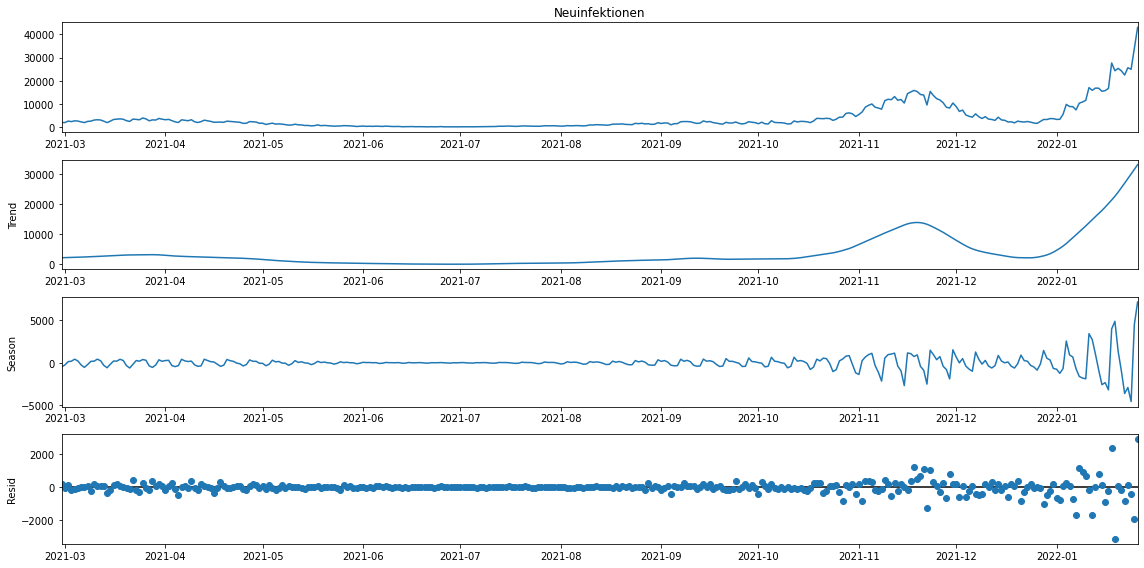

In [7]:
decomposed = STL(data.loc[data["Name"] == "Österreich", "Neuinfektionen"], period=7).fit()
plt.rc("figure", figsize=(16, 8))
decomposed.plot()
plt.show()


### Neuinfektionen (Vorausberechnung)

In [8]:
infektionen = data.loc[data["Name"] == "Österreich", "Neuinfektionen"].tail(15)
fcst = STLForecast(infektionen, ARIMA, period=7, model_kwargs={"order": (2, 1, 0)}).fit().forecast(7)
pd.DataFrame(fcst.apply(lambda x: f'{x:,.0f}'.replace(",", " ")), columns = ["Neuinfektionen"])

C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Python3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


,Neuinfektionen
2022-01-27,35 772
2022-01-28,33 752
2022-01-29,30 595
2022-01-30,32 375
2022-01-31,30 243
2022-02-01,37 819
2022-02-02,44 271


## Hospitalisierung
### Werte der letzten 7 Tage

In [9]:
hosp = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "Hospitalisierung": data.tail(7*10)["Hospitalisierung"],
        "Diff": data.tail(7*10)["HospitalisierungDiff"],
    }
)
hosp["HospitalisierungPrint"] = hosp.apply(lambda x: f'{x.Hospitalisierung:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
hosp.pivot(values="HospitalisierungPrint", columns="Name")


Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-20,44 (5),113 (-2),144 (-5),128 (2),73 (2),118 (3),130 (7),50 (5),308 (2),1 108 (19)
2022-01-21,45 (1),100 (-13),152 (8),125 (-3),75 (2),119 (1),126 (-4),48 (-2),336 (28),1 126 (18)
2022-01-22,47 (2),98 (-2),168 (16),133 (8),80 (5),104 (-15),120 (-6),47 (-1),332 (-4),1 129 (3)
2022-01-23,46 (-1),108 (10),165 (-3),147 (14),85 (5),113 (9),122 (2),55 (8),359 (27),1 200 (71)
2022-01-24,50 (4),119 (11),179 (14),163 (16),89 (4),133 (20),136 (14),54 (-1),361 (2),1 284 (84)
2022-01-25,52 (2),121 (2),183 (4),156 (-7),92 (3),141 (8),146 (10),56 (2),369 (8),1 316 (32)
2022-01-26,53 (1),122 (1),191 (8),153 (-3),90 (-2),145 (4),143 (-3),57 (1),361 (-8),1 315 (-1)


### Diagramm

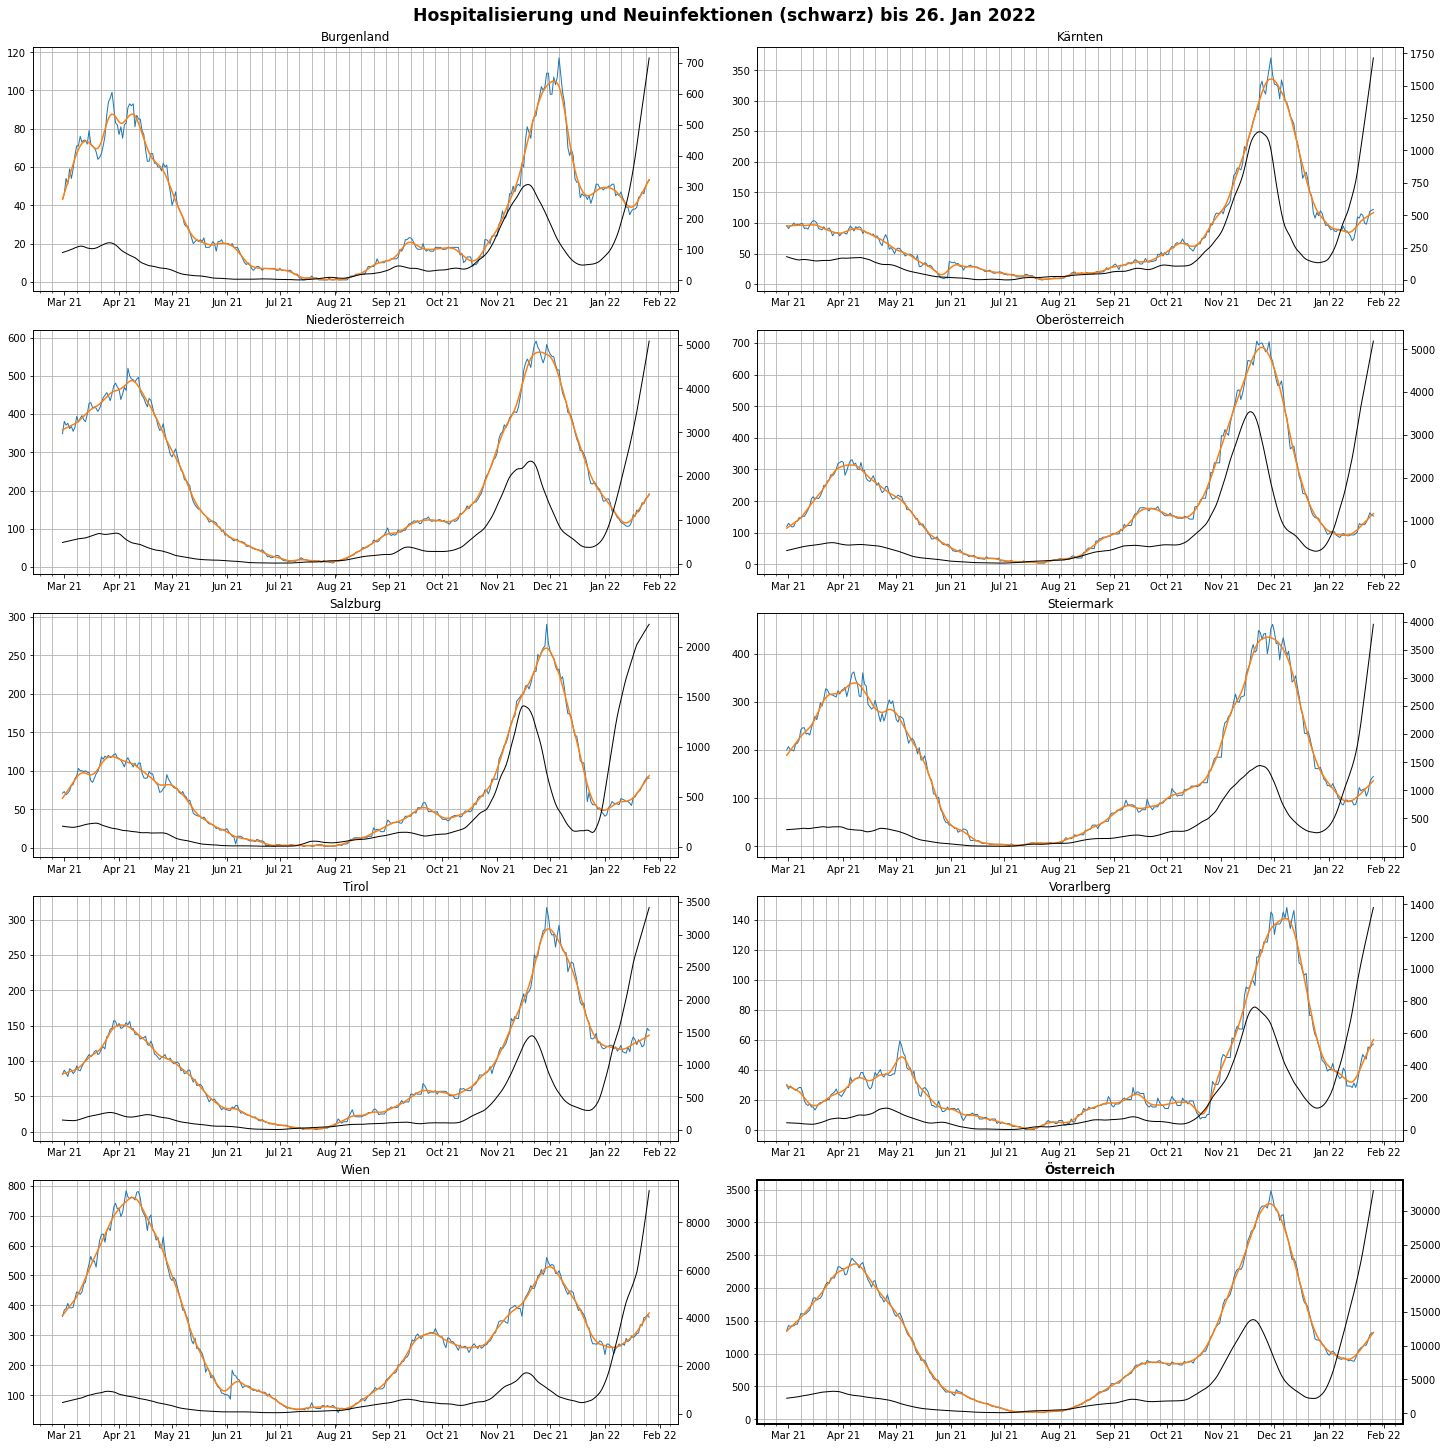

In [10]:

plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz)", data)


### Logarithmischer Plot

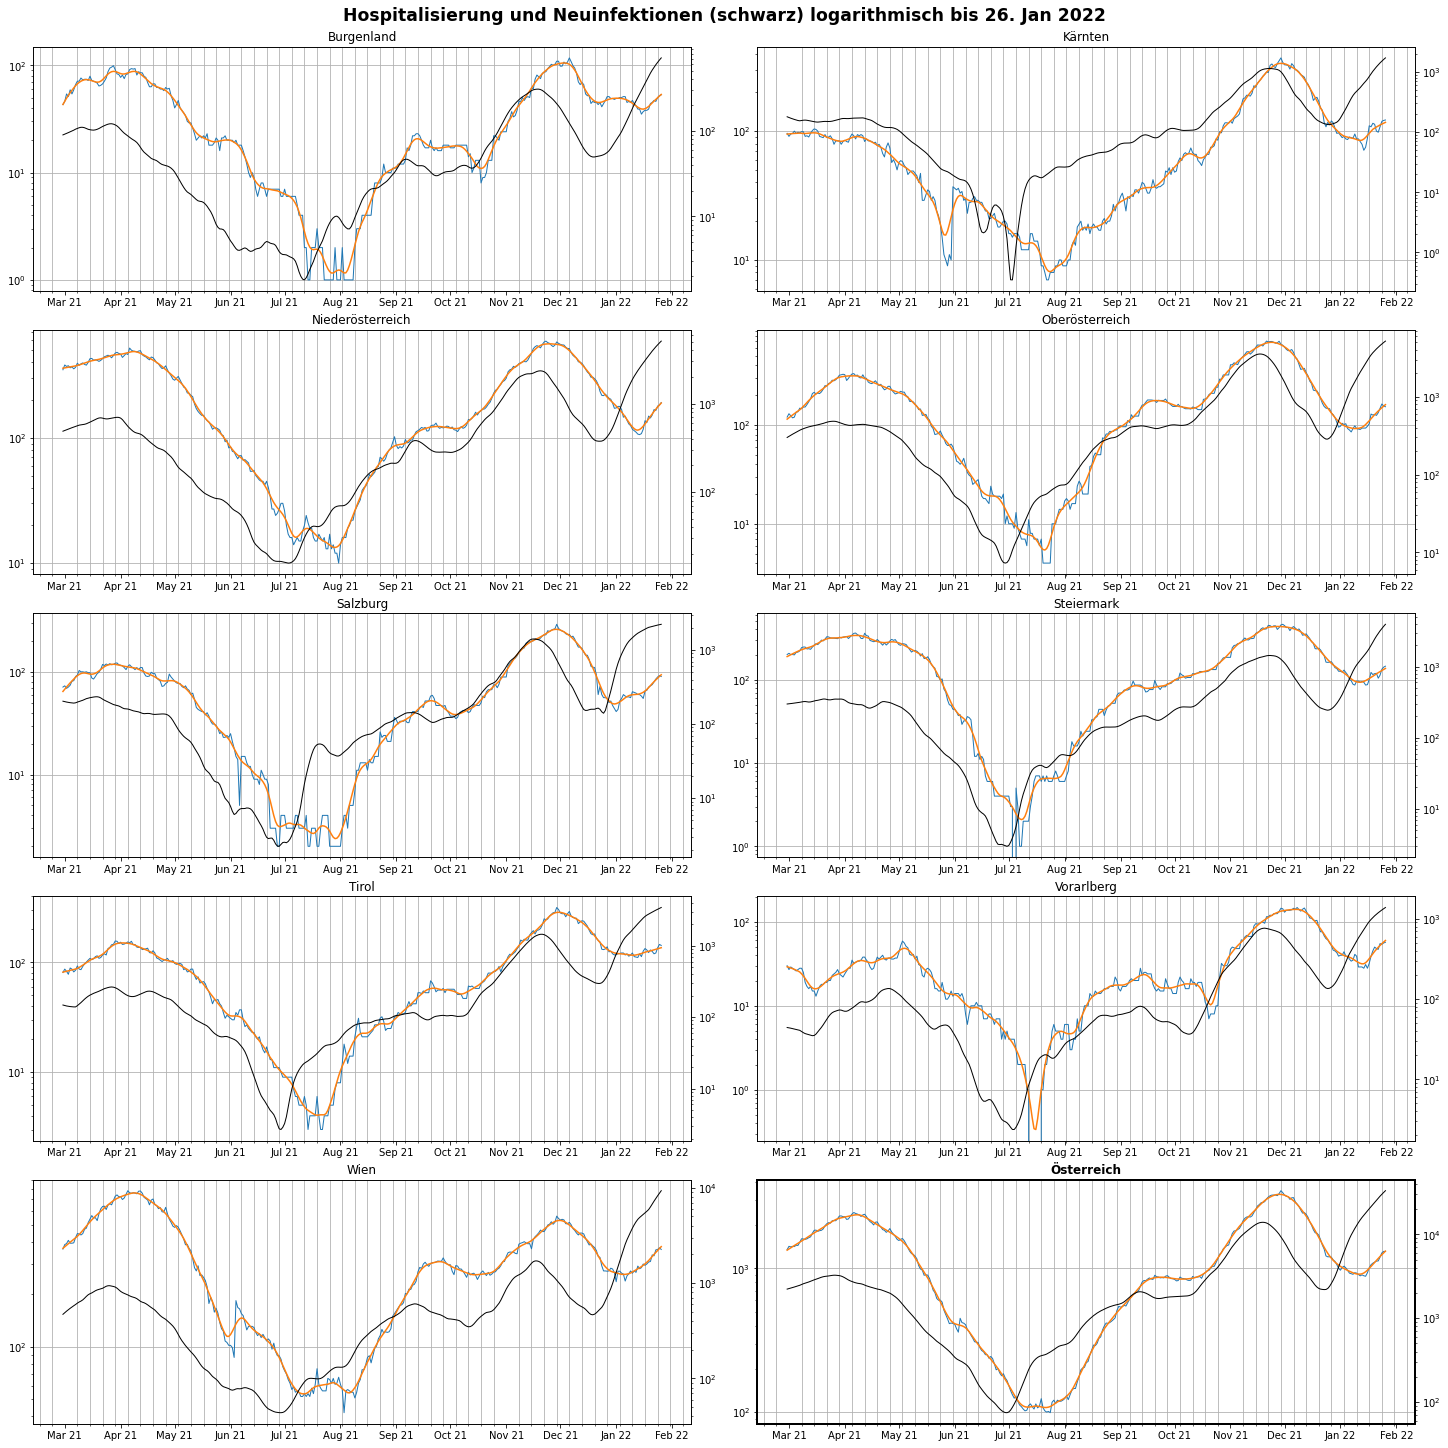

In [11]:
plot_param(["Hospitalisierung", "Neuinfektionen"],
           "Hospitalisierung und Neuinfektionen (schwarz) logarithmisch", data, log=True)

## Durchgeführte PCR Tests
### Werte der letzten 7 Tage

In [12]:
pcrTaeglich = pd.DataFrame(
    {
        "Name": data.tail(7*10)["Name"],
        "TestungenPCR": data.tail(7*10)["TestungenPCR"],
        "Diff": data.tail(8*10)["TestungenPCR"].diff(periods=10).tail(7*10)
    }
)
pcrTaeglich["TestungenPrint"] = pcrTaeglich.apply(lambda x: f'{x.TestungenPCR:,.0f} ({x.Diff:,.0f})'.replace(",", " "), axis=1)
pcrTaeglich.pivot(values="TestungenPrint", columns="Name")

Name,Burgenland,Kärnten,Niederösterreich,Oberösterreich,Salzburg,Steiermark,Tirol,Vorarlberg,Wien,Österreich
Datum,,,,,,,,,,
2022-01-20,11 313 (4 152),11 392 (5 548),18 870 (-191 715),54 610 (21 055),15 241 (-4 717),30 951 (0),26 447 (-1 452),9 326 (-251),388 260 (88 691),566 410 (-78 689)
2022-01-21,11 387 (74),12 801 (1 409),43 429 (24 559),33 813 (-20 797),26 364 (11 123),40 650 (9 699),24 490 (-1 957),8 631 (-695),268 756 (-119 504),470 321 (-96 089)
2022-01-22,17 059 (5 672),10 464 (-2 337),37 710 (-5 719),47 762 (13 949),18 312 (-8 052),23 494 (-17 156),23 486 (-1 004),7 939 (-692),233 260 (-35 496),419 486 (-50 835)
2022-01-23,7 933 (-9 126),5 690 (-4 774),29 154 (-8 556),43 401 (-4 361),17 798 (-514),24 878 (1 384),20 103 (-3 383),9 417 (1 478),232 268 (-992),390 642 (-28 844)
2022-01-24,11 830 (3 897),4 311 (-1 379),45 411 (16 257),32 694 (-10 707),12 368 (-5 430),34 188 (9 310),30 023 (9 920),7 377 (-2 040),260 909 (28 641),439 111 (48 469)
2022-01-25,5 874 (-5 956),16 812 (12 501),36 806 (-8 605),61 536 (28 842),22 901 (10 533),44 932 (10 744),28 177 (-1 846),11 258 (3 881),428 099 (167 190),656 395 (217 284)
2022-01-26,7 810 (1 936),9 683 (-7 129),368 004 (331 198),44 653 (-16 883),23 488 (587),35 071 (-9 861),30 360 (2 183),10 302 (-956),334 594 (-93 505),863 965 (207 570)


### Diagramm

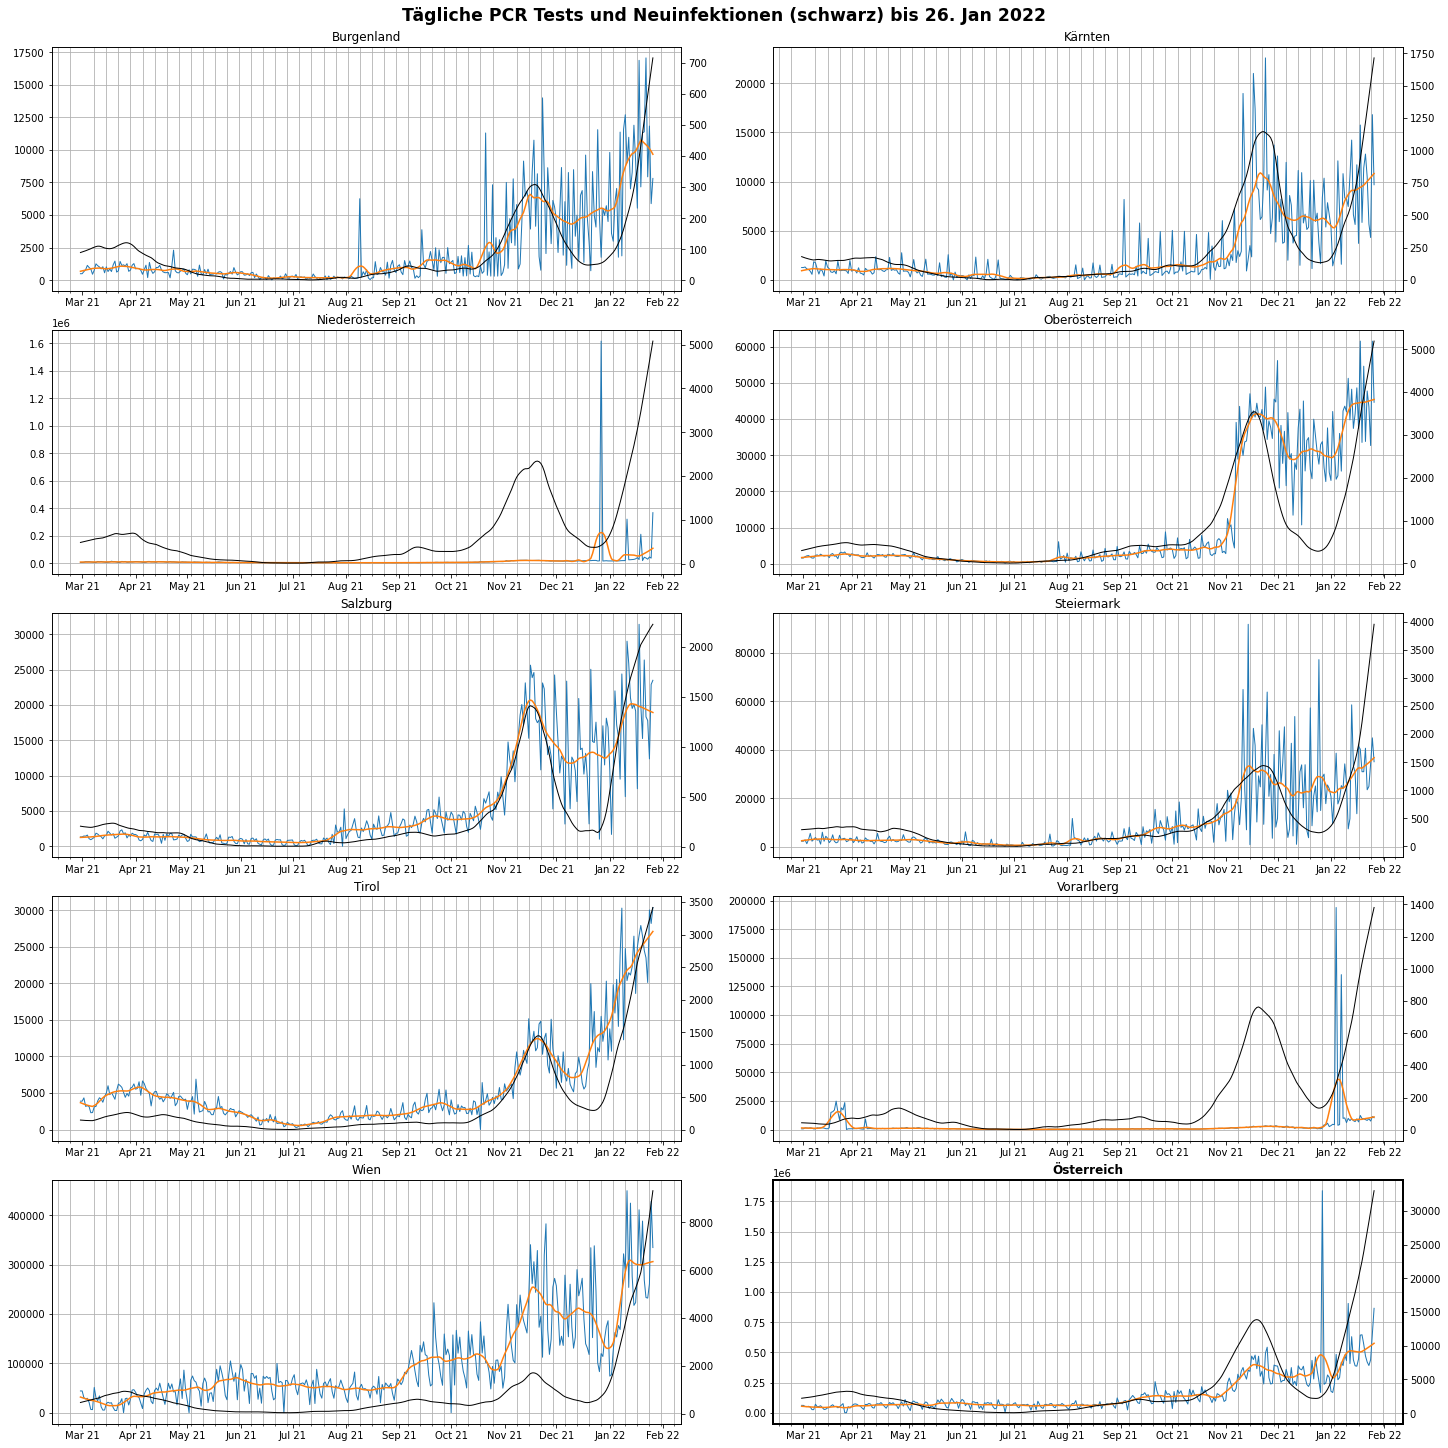

In [13]:
plot_param(["TestungenPCR", "Neuinfektionen"], "Tägliche PCR Tests und Neuinfektionen (schwarz)", data)